# Определение возраста покупателей

## Исследовательский анализ данных

### Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

В рамках данного проекта будет построена модель, которая по фотографии определит приблизительный возраст человека. 

В нашем распоряжении набор фотографий людей с указанием возраста.

Задачи:

1. Провести исследовательский анализ набора фотографий.
2. Подготовить данные к обучению.
3. Обучить нейронную сеть и рассчитать её качество.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dense, Conv2D, AvgPool2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.isna().sum()

file_name    0
real_age     0
dtype: int64

In [6]:
labels.duplicated().sum()

0

Пропусков и дубликатов не обнаружено.

In [7]:
labels.columns

Index(['file_name', 'real_age'], dtype='object')

In [8]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Описание describe: 
- В выборке 7591 строк с картинками и возрастами.
- Средний возраст 32.2 года , медиана - 29 лет.
- Максимальный возраст - 100 лет, минимальный - 1 год.


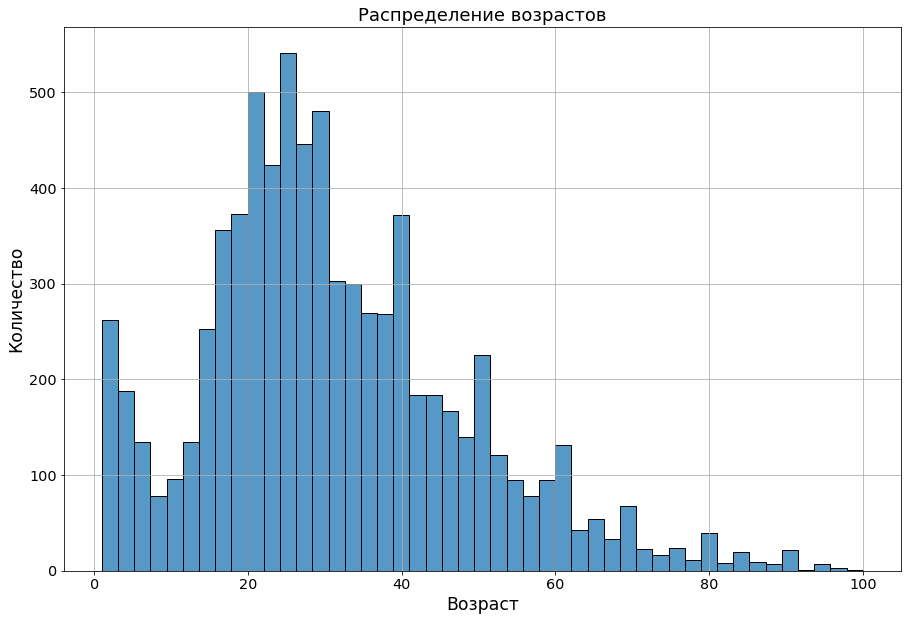

In [9]:
plt.figure(figsize=(15,10))
sns.histplot(labels, x = 'real_age')
plt.title('Распределение возрастов', fontsize='18')
plt.xlabel('Возраст', fontsize='xx-large')
plt.ylabel('Количество', fontsize='xx-large')
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.grid()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Возраст')

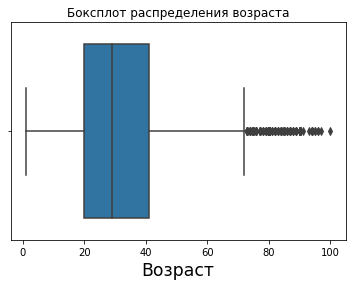

In [10]:
sns.boxplot(labels['real_age'])
plt.title('Боксплот распределения возраста')
plt.xlabel('Возраст', fontsize='xx-large')


In [11]:
features, target = next(train_gen_flow)

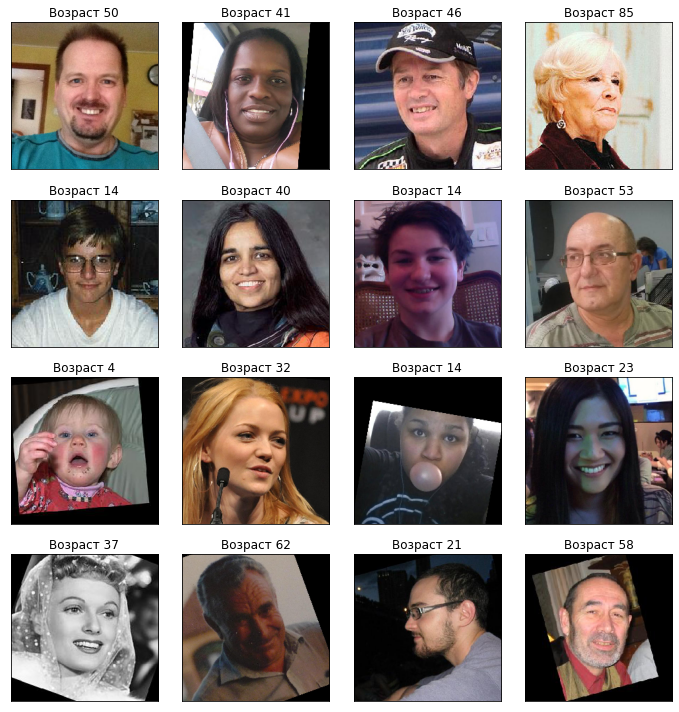

In [12]:
# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'Возраст {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Выводы:

1. В датасете 7591 фотографий.
2. Больше всего фотографий в диапазоне от 20 лет до 41 года.
3. В выборке размечены дети и старики. На возрасте 60+ довольно мало примеров, вероятно на этих возрастах модель плохо обучится и будут ошибки на предсказаниях пожилых людей. 
4. Имеется пик на возрасте до 10-и лет.Есть фото детей. Для магазина это не очень нужно.
5. Распределение по возрастам нормальное, выбросов не наблюдается.
6. Фотографии выглядят хорошо. Однако лицо повернуто в разные стороны и присутствуют повернутые до 15 градусов изображения. Чтобы улучшить обучение, думаю будет полезным, применить горизонтальный разворот изображений и ротацию в аугментации при загрузке.


In [13]:
# < Перенесите сюда исследовательский анализ данных >

## Обучение модели

В ячейке ниже показан код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
def load_test(path):
    labels = pd.read_csv(path+'labels.csv') 
    test_datagen = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    return test_datagen_flow


def load_train(path):
    labels = pd.read_csv(path+'labels.csv') 
    train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.25,
                                   horizontal_flip=True,
                                   rotation_range=15)

    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
      directory=path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      subset='training',
      seed=12345)
    return train_datagen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer,loss='mse',metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
# < скопируйте код сюда >

```

```
178/178 - 123s - loss: 249.3007 - mae: 11.9785 - val_loss: 363.4407 - val_mae: 15.9890
Epoch 2/10
178/178 - 115s - loss: 170.2188 - mae: 9.9948 - val_loss: 288.2704 - val_mae: 12.8142
Epoch 3/10
178/178 - 114s - loss: 150.6850 - mae: 9.4176 - val_loss: 409.7737 - val_mae: 15.0730
Epoch 4/10
178/178 - 114s - loss: 141.3327 - mae: 9.0390 - val_loss: 215.7236 - val_mae: 11.2329
Epoch 5/10
178/178 - 113s - loss: 121.1415 - mae: 8.4211 - val_loss: 269.2757 - val_mae: 11.8929
Epoch 6/10
178/178 - 114s - loss: 122.4766 - mae: 8.3754 - val_loss: 117.7882 - val_mae: 8.5508
Epoch 7/10
178/178 - 110s - loss: 111.9560 - mae: 8.0300 - val_loss: 188.8792 - val_mae: 10.2642
Epoch 8/10
178/178 - 108s - loss: 104.6827 - mae: 7.7606 - val_loss: 274.5902 - val_mae: 14.0431
Epoch 9/10
178/178 - 106s - loss: 101.0894 - mae: 7.6274 - val_loss: 160.3872 - val_mae: 9.5828
Epoch 10/10
178/178 - 107s - loss: 93.2515 - mae: 7.3138 - val_loss: 109.9622 - val_mae: 7.8661


# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

```

**Вывод:** Лучший результат MAE на тестовой выборке: 7.8661. Задание выполнено.

## Анализ обученной модели

Была поставлена задача построить и обучить модель, которая поможет определять возраст человека по изображению с камеры со средним абсолютным отклонением MAE меньше 8.

В нашем распоряжении был датасет с 7591 размеченной фотографией. Среди фотографий наблюдался поворот лица по горизонтали и вращение до 15 градусов. 

Для обучения модели выборка разделена на тренировочную и валидационную в соотношении 1:3, Для тренировочныой выборки использовали специальные гиперпараметры - аугментацию, а валдационную часть оставили без изменений для тестирования модели.

В качестве основы за модель взяли уже предобученную нейросеть с архитектурой ResNet50 и использовали её без замораживания. В выходном слое,для более точного обучения модели, использовали оптимизацию Adam c шагом обучения 0.001, а в качестве функции потерь использовалась mean_squared_error (mse).

С такими параметрами мы протестировали нашу модель и на 10 эпохе обучения на тестовых данных, она достигла значения по метрике MAE равное 7.8661, что уже меньше 8. Таким образом мы достигли требуемой точности предсказания возраста нашей моделью и можем рекомендовать её к использованию.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы